In [1]:
%pylab inline
%config InlineBackend.figure_format = 'retina'

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
import pandas as pd
import sys
import tensorflow as tf

Populating the interactive namespace from numpy and matplotlib


In [2]:
data_path = 'data/hour.csv'

rides = pd.read_csv(data_path)

In [3]:
dummy_fields = ['season', 'weathersit', 'mnth', 'hr', 'weekday']
for each in dummy_fields:
    dummies = pd.get_dummies(rides[each], prefix=each, drop_first=False)
    rides = pd.concat([rides, dummies], axis=1)

fields_to_drop = ['instant', 'dteday', 'season', 'weathersit', 
                  'weekday', 'atemp', 'mnth', 'workingday', 'hr']
data = rides.drop(fields_to_drop, axis=1)

In [4]:
quant_features = ['casual', 'registered', 'cnt', 'temp', 'hum', 'windspeed']
# Store scalings in a dictionary so we can convert back later
scaled_features = {}
for each in quant_features:
    mean, std = data[each].mean(), data[each].std()
    scaled_features[each] = [mean, std]
    data.loc[:, each] = (data[each] - mean)/std

In [5]:
# Save the last 21 days 
test_data = data[-21*24:]
data = data[:-21*24]

# Separate the data into features and targets
target_fields = ['cnt', 'casual', 'registered']
#target_fields = ['cnt']

features, targets = data.drop(target_fields, axis=1), data['cnt'].values
targets.resize(targets.size, 1)

test_features, test_targets = test_data.drop(target_fields, axis=1), test_data['cnt'].values
test_targets.resize(test_targets.size, 1)


In [6]:
# Hold out the last 60 days of the remaining data as a validation set
train_features, train_targets = features[:-60*24], targets[:-60*24]
val_features, val_targets = features[-60*24:], targets[-60*24:]

In [7]:
# number of features
train_features.shape[1], train_targets.shape

(56, (15435, 1))

In [8]:
def neural_net_feature_input(n_features):
    """
    Return a Tensor for a batch of training features
    : shape: Shape of feature: number of features
    : return: Tensor for input.
    """
    return tf.placeholder(tf.float32, shape = [None, n_features], name = 'x')

def neural_net_target_input():
    """
    Return a Tensor for a batch of label input
    : single dimension as input
    : return: Tensor for input.
    """
    return tf.placeholder(tf.float32, shape = [None, 1], name = 'y')

In [9]:
# construct 2 layer network
def neural_net(x_tensor):
    w1 = tf.Variable(tf.truncated_normal([56, 112],stddev=0.1))
    b1 = tf.Variable(tf.zeros(112))
    layer1 = tf.add(tf.matmul(x_tensor, w1), b1)
    layer1 = tf.nn.sigmoid(layer1)
    
    w2 = tf.Variable(tf.truncated_normal([112, 56],stddev=0.1))
    b2 = tf.Variable(tf.zeros([56]))
    layer2 = tf.add(tf.matmul(layer1, w2), b2)
    layer2 = tf.nn.sigmoid(layer2)
    
    w3 = tf.Variable(tf.truncated_normal([56, 1],stddev=0.1))
    b3 = tf.Variable(tf.zeros([1]))
    predictions = tf.add(tf.matmul(layer2, w3), b3)
    return predictions

In [10]:
def next(features, iterator, batch_size):
    start_index = iterator*batch_size
    end_index = (iterator+1)*batch_size
    return features[start_index:end_index]

In [11]:
n_features = train_features.shape[1]
learning_rate = 0.01

x = neural_net_feature_input(n_features)
y = neural_net_target_input()

pred = neural_net(x)

# cost
cost_op = tf.reduce_mean(tf.pow(pred - y, 2))
# Gradient descent
optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost_op)

batch size =  50
number batches =  308
--- Beginning Training ---
Progress: 21% ... Training loss: 0.05722 ... Validation loss: 0.11608--- EARLY STOPPING ---

Predictions versus test set
Prediction
real	predicted
-0.3	-0.2
-0.6	-0.5
-0.9	-1.1
-1.0	-0.9
-1.0	-1.0
-1.0	-1.2
-1.0	-1.0
-0.8	-1.1
-0.4	-0.3
1.1	1.2


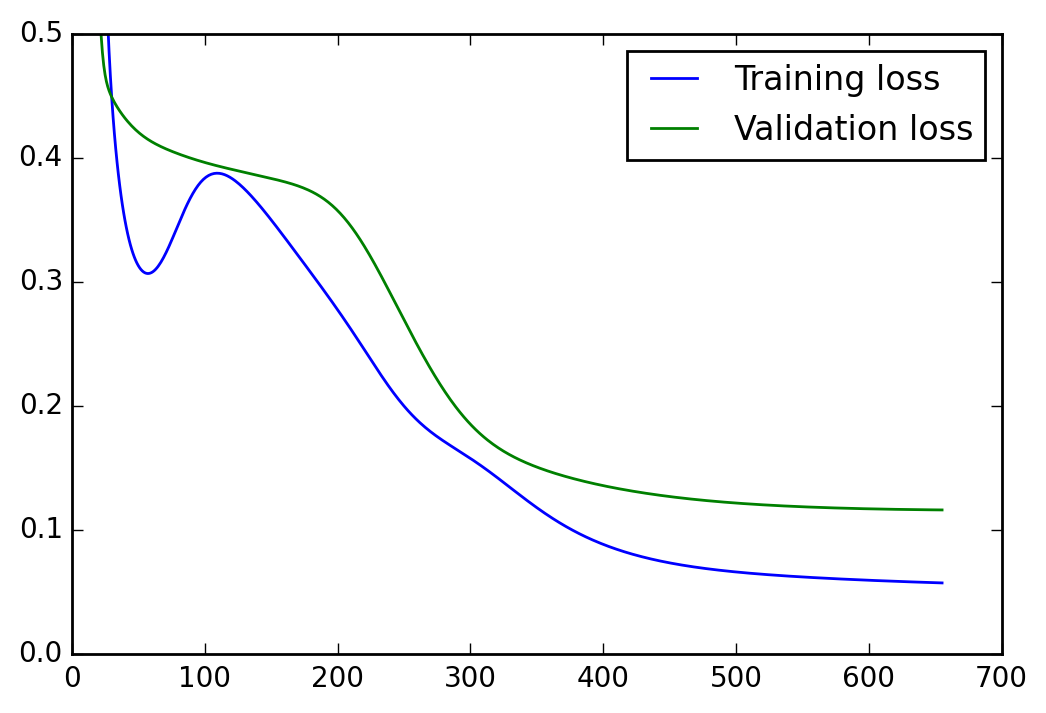

In [28]:
epochs  = 3000      
batch_size  = 50         
num_samples = train_targets.shape[0]                
num_batches = int(num_samples / batch_size)   
early_stopping = 1e-5
last_loss = 0
    

print( "batch size = ", batch_size )
print( "number batches = ", num_batches )
print( "--- Beginning Training ---" )

with tf.Session() as sess:
    
    init = tf.global_variables_initializer()
    sess.run(init)
    
    losses = {'train':[], 'validation':[]}
    for i in range(epochs):
        for n in range(num_batches):
            batch_x = next(train_features, n, batch_size)
            batch_y = next(train_targets, n, batch_size)
            sess.run(optimizer, feed_dict={x: batch_x, y: batch_y} )

    
        train_loss = sess.run(cost_op, feed_dict={x: train_features, y: train_targets}) 
        val_loss = sess.run(cost_op, feed_dict={x: val_features, y: val_targets})
        sys.stdout.write("\rProgress: " + str(100 * i/float(epochs))[:2] \
                     + "% ... Training loss: " + str(train_loss)[:7] \
                     + " ... Validation loss: " + str(val_loss)[:7])
    
        losses['train'].append(train_loss)
        losses['validation'].append(val_loss)
        
        if abs(last_loss - val_loss) < early_stopping:
            print( "--- EARLY STOPPING ---")
            predictions = sess.run(pred, feed_dict={x: test_features, y: test_targets} )
            print( "\nPredictions versus test set\nPrediction\nreal\tpredicted" )
            for (x, y) in zip( test_targets, predictions )[0:10]:
                print( "%1.1f\t%1.1f" % (x, y))
                
            plt.plot(losses['train'], label='Training loss')
            plt.plot(losses['validation'], label='Validation loss')
            plt.legend()
            plt.ylim(ymax=0.5)
            
            break
                    
        last_loss = val_loss
        

In [ ]:
# no early stopping
epochs  = 500     
batch_size  = 50         
num_samples = train_targets.shape[0]                
num_batches = int(num_samples / batch_size)   
last_loss = 0
    

print( "batch size = ", batch_size )
print( "number batches = ", num_batches )
print( "--- Beginning Training ---" )

with tf.Session() as sess:
    
    init = tf.global_variables_initializer()
    sess.run(init)
    
    losses = {'train':[], 'validation':[]}
    for i in range(epochs):
        for n in range(num_batches):
            batch_x = next(train_features, n, batch_size)
            batch_y = next(train_targets, n, batch_size)
            sess.run(optimizer, feed_dict={x: batch_x, y: batch_y} )

    
        train_loss = sess.run(cost_op, feed_dict={x: train_features, y: train_targets}) 
        val_loss = sess.run(cost_op, feed_dict={x: val_features, y: val_targets})
        sys.stdout.write("\rProgress: " + str(100 * i/float(epochs))[:2] \
                     + "% ... Training loss: " + str(train_loss)[:6] \
                     + " ... Validation loss: " + str(val_loss)[:6])
    
        losses['train'].append(train_loss)
        losses['validation'].append(val_loss)
        last_loss = train_loss
        
    predictions = sess.run(pred, feed_dict={x: test_features, y: test_targets} )
    
    print( "\nPredictions versus test set\nPrediction\nreal\tpredicted" )
    for (x, y) in zip( test_targets, predictions )[0:10]:
        print( "%1.1f\t%1.1f" % (x, y))
        
    plt.plot(losses['train'], label='Training loss')
    plt.plot(losses['validation'], label='Validation loss')
    plt.legend()
    plt.ylim(ymax=0.5)

batch size =  50
number batches =  308
--- Beginning Training ---
Progress: 45% ... Training loss: 0.1875 ... Validation loss: 0.3031